<a href="https://colab.research.google.com/github/Sidshx/hardware_for_AI/blob/main/Fibonacci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Python 3.11.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpjjvlns_z".


In [7]:
%%cuda
#include <cstdio>
#include <chrono>
const int N = 220;

int main() {
    // allocate host buffer
    unsigned long long *h = new unsigned long long[N];

    // CPU sequential Fibonacci
    auto t0 = std::chrono::high_resolution_clock::now();
    h[0] = 0;
    h[1] = 1;
    for (int i = 2; i < N; ++i) {
        h[i] = h[i-1] + h[i-2];
    }
    auto t1 = std::chrono::high_resolution_clock::now();
    double cpu_ms = std::chrono::duration<double, std::milli>(t1 - t0).count();

    // print result and timing
    printf("F[%d] = %llu  (CPU)\n", N-1, h[N-1]);
    printf("CPU time: %.3f ms\n\n", cpu_ms);

    delete[] h;
    return 0;
}


F[219] = 1515993335950401858  (CPU)
CPU time: 0.001 ms




In [12]:
%%bash
cat > fib.cu <<'EOF'
#include <cstdio>
#include <chrono>

const int N = 220;

__global__ void fib_kernel(unsigned long long *d, int n) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx >= n) return;
    if      (idx < 2)      d[idx] = idx;
    else {
        unsigned long long a=0, b=1, c;
        for (int i = 2; i <= idx; ++i) {
            c = a + b; a = b; b = c;
        }
        d[idx] = b;
    }
}

int main() {
    unsigned long long *h = new unsigned long long[N], *d;
    cudaMalloc(&d, N * sizeof(*d));

    auto t0 = std::chrono::high_resolution_clock::now();
    fib_kernel<<<(N + 255) / 256, 256>>>(d, N);
    cudaDeviceSynchronize();
    auto t1 = std::chrono::high_resolution_clock::now();

    cudaMemcpy(h, d, N * sizeof(*d), cudaMemcpyDeviceToHost);

    printf("F[%d] = %llu  (GPU)\n", N - 1, h[N - 1]);
    printf("GPU kernel time: %.3f ms\n",
       std::chrono::duration<double, std::milli>(t1 - t0).count());

    cudaFree(d);
    delete[] h;
    return 0;
}
EOF


In [13]:
%%bash
# tell nvcc to only generate cubin for sm_75 (Tesla T4)
nvcc -arch=sm_75 \
     -gencode=arch=compute_75,code=sm_75 \
     fib.cu -o fib

./fib


F[219] = 1515993335950401858  (GPU)
GPU kernel time: 0.155 ms


Kernel execution timeline

In [21]:
%%bash
# 1) Simple CPU Fibonacci
cat > fib_cpu.cpp << 'EOF'
#include <iostream>
#include <vector>
#include <chrono>
#include <cstdlib>
int main(int argc, char** argv) {
    int N = (argc>1)? std::atoi(argv[1]) : 220;
    std::vector<unsigned long long> F(N+1);
    F[0]=0; F[1]=1;
    auto t0 = std::chrono::high_resolution_clock::now();
    for(int i=2;i<=N;i++) F[i]=F[i-1]+F[i-2];
    auto t1 = std::chrono::high_resolution_clock::now();
    double dt = std::chrono::duration<double,std::milli>(t1-t0).count();
    std::cout<<dt;
    return 0;
}
EOF
g++ -O2 fib_cpu.cpp -o fib_cpu

# 2) Instrumented CPU Fibonacci (init, compute, finalize)
cat > fib_cpu_ins.cpp << 'EOF'
#include <iostream>
#include <vector>
#include <chrono>
#include <cstdlib>
int main(int argc, char** argv) {
    int N = (argc>1)? std::atoi(argv[1]) : 220;
    auto t0 = std::chrono::high_resolution_clock::now();

    std::vector<unsigned long long> F(N+1);
    F[0]=0; F[1]=1;
    auto t1 = std::chrono::high_resolution_clock::now();

    for(int i=2;i<=N;i++) F[i]=F[i-1]+F[i-2];
    auto t2 = std::chrono::high_resolution_clock::now();

    // any finalization (none here except printing)
    double init   = std::chrono::duration<double,std::milli>(t1-t0).count();
    double compute= std::chrono::duration<double,std::milli>(t2-t1).count();
    auto t3 = std::chrono::high_resolution_clock::now();
    double finalize = std::chrono::duration<double,std::milli>(t3-t2).count();

    std::cout<<init<<" "<<compute<<" "<<finalize;
    return 0;
}
EOF
g++ -O2 fib_cpu_ins.cpp -o fib_cpu_ins

# 3) Simple GPU Fibonacci
cat > fib.cu << 'EOF'
#include <cstdio>
#include <chrono>
#include <cstdlib>
__global__ void fib_kernel(unsigned long long *d, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx>=n) return;
    if(idx<2) d[idx]=idx;
    else {
        unsigned long long a=0,b=1,c;
        for(int i=2;i<=idx;i++){ c=a+b; a=b; b=c; }
        d[idx]=b;
    }
}
int main(int argc, char** argv) {
    int N = (argc>1)? std::atoi(argv[1]) : 220;
    unsigned long long *h=new unsigned long long[N], *d;
    cudaMalloc(&d,N*sizeof(*d));
    cudaMemset(d,0,N*sizeof(*d));
    auto t0 = std::chrono::high_resolution_clock::now();
    fib_kernel<<<(N+255)/256,256>>>(d,N);
    cudaDeviceSynchronize();
    auto t1 = std::chrono::high_resolution_clock::now();
    cudaMemcpy(h,d,N*sizeof(*h),cudaMemcpyDeviceToHost);
    double dt = std::chrono::duration<double,std::milli>(t1-t0).count();
    printf("%.6f", dt);
    cudaFree(d); delete[] h;
    return 0;
}
EOF
nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 fib.cu -o fib

# 4) Instrumented GPU Fibonacci (launch, exec, copy)
cat > fib_ins.cu << 'EOF'
#include <cstdio>
#include <chrono>
#include <cstdlib>
__global__ void fib_kernel(unsigned long long *d, int n) {
    int idx = blockIdx.x*blockDim.x + threadIdx.x;
    if(idx>=n) return;
    if(idx<2) d[idx]=idx;
    else {
        unsigned long long a=0,b=1,c;
        for(int i=2;i<=idx;i++){ c=a+b; a=b; b=c; }
        d[idx]=b;
    }
}
int main(int argc, char** argv) {
    int N = (argc>1)? std::atoi(argv[1]) : 220;
    unsigned long long *h=new unsigned long long[N], *d;
    cudaMalloc(&d,N*sizeof(*d));
    cudaMemset(d,0,N*sizeof(*d));

    auto t0 = std::chrono::high_resolution_clock::now();
    fib_kernel<<<(N+255)/256,256>>>(d,N);
    auto t1 = std::chrono::high_resolution_clock::now();
    cudaDeviceSynchronize();
    auto t2 = std::chrono::high_resolution_clock::now();
    cudaMemcpy(h,d,N*sizeof(*h),cudaMemcpyDeviceToHost);
    auto t3 = std::chrono::high_resolution_clock::now();

    double launch  = std::chrono::duration<double,std::milli>(t1-t0).count();
    double exec    = std::chrono::duration<double,std::milli>(t2-t1).count();
    double copyback= std::chrono::duration<double,std::milli>(t3-t2).count();
    printf("%.6f %.6f %.6f", launch, exec, copyback);

    cudaFree(d); delete[] h; return 0;
}
EOF
nvcc -arch=sm_75 -gencode=arch=compute_75,code=sm_75 fib_ins.cu -o fib_ins


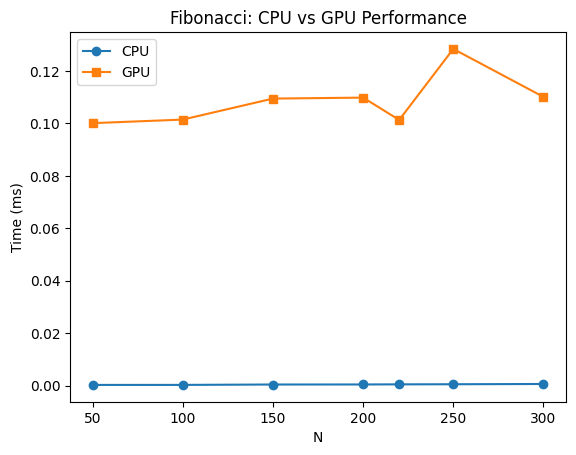

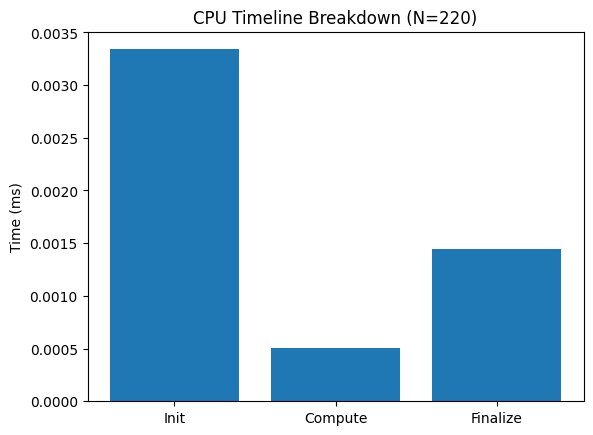

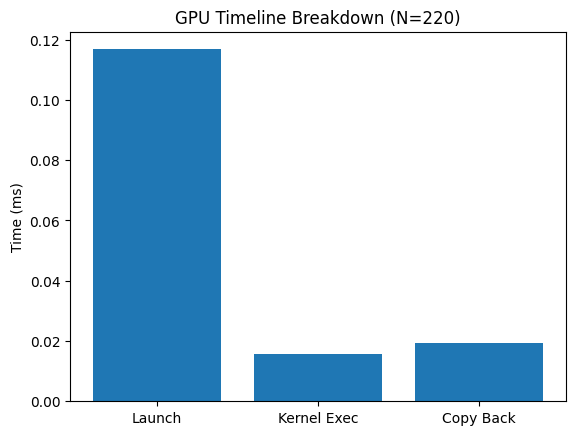

In [22]:
import subprocess
import matplotlib.pyplot as plt

# 1) Performance vs N
Ns = [50,100,150,200,220,250,300]
cpu_ms, gpu_ms = [], []

for N in Ns:
    cpu_ms.append(float(subprocess.check_output(['./fib_cpu', str(N)])))
    gpu_ms.append(float(subprocess.check_output(['./fib', str(N)], text=True)))

plt.plot(Ns, cpu_ms, 'o-', label='CPU')
plt.plot(Ns, gpu_ms, 's-', label='GPU')
plt.xlabel('N')
plt.ylabel('Time (ms)')
plt.title('Fibonacci: CPU vs GPU Performance')
plt.legend()
plt.show()

# 2) CPU timeline breakdown at N=220
init_t, comp_t, fin_t = map(float, subprocess.check_output(['./fib_cpu_ins','220'], text=True).split())
plt.figure()
plt.bar(['Init','Compute','Finalize'], [init_t, comp_t, fin_t])
plt.ylabel('Time (ms)')
plt.title('CPU Timeline Breakdown (N=220)')
plt.show()

# 3) GPU timeline breakdown at N=220
launch_t, exec_t, copy_t = map(float, subprocess.check_output(['./fib_ins','220'], text=True).split())
plt.figure()
plt.bar(['Launch','Kernel Exec','Copy Back'], [launch_t, exec_t, copy_t])
plt.ylabel('Time (ms)')
plt.title('GPU Timeline Breakdown (N=220)')
plt.show()
